In [1]:
import scipy.io
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import numpy as np
from numpy import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
data_dict = {'Lung_Lesion': 0,
 'Atelectasis': 1,
 'No_Finding': 2,
 'Edema': 3,
 'Lung_Opacity': 4,
 'Cardiomegaly': 5,
 'Pleural_Other': 6,
 'Fracture': 7,
 'Pneumonia': 8,
 'Enlarged_Cardiomediastinum': 9,
 'Pleural_Effusion': 10,
 'Pneumothorax': 11,
 'Support_Devices': 12,
 'Consolidation': 13}

In [3]:
test_img = 'Data/No_Finding/frontal_0.jpg'

In [4]:
plt.imshow(_load_image(test_img), cmap= 'gray')

NameError: name '_load_image' is not defined

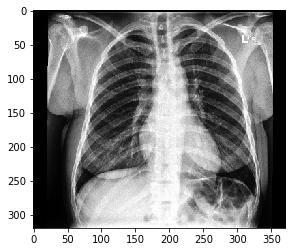

In [27]:
plt.imshow(plt.imread(test_img), cmap='gray')

In [15]:
def equalize(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(img)
    return cl

def _load_image(path):
    image = cv2.imread(path,0)
    if image is not None:
        image = equalize(image)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        image = cv2.resize(image, (299,299))
        return image
    return None

In [6]:
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [7]:
def _build_examples_list(input_folder, seed):
    examples = []
    for classname in os.listdir(input_folder):
        class_dir = os.path.join(input_folder, classname)
        if (os.path.isdir(class_dir)):
            for filename in os.listdir(class_dir):
                filepath = os.path.join(class_dir, filename)
                example = {
                    'classname': classname, 
                    'path': filepath,
                    'label': data_dict[classname]
                }
                examples.append(example)

    random.seed(seed)
    random.shuffle(examples)
    return examples

In [8]:
def _split_list(alist, wanted_parts=1):
    length = len(alist)
    return [ alist[i*length // wanted_parts: (i+1)*length // wanted_parts] 
             for i in range(wanted_parts) ]

In [9]:
def _get_examples_share(examples, training_split):
    examples_size = len(examples)
    len_training_examples = int(examples_size * training_split)

    return np.split(examples, [len_training_examples])

In [10]:
def _write_tfrecord(examples, output_filename):
    writer = tf.io.TFRecordWriter(output_filename)
    for example in tqdm(examples):
        try:
            image = _load_image(example['path'])
            if image is not None:
                encoded_image_string = cv2.imencode('.jpg', image)[1].tostring()
                feature = {
                    'label': _bytes_feature(tf.compat.as_bytes(str(example['label']))),
                    'image': _bytes_feature(tf.compat.as_bytes(encoded_image_string)),
                    'classname': _bytes_feature(tf.compat.as_bytes(example['classname']))
                }

                tf_example = tf.train.Example(features = tf.train.Features(feature=feature))
                writer.write(tf_example.SerializeToString())
        except Exception as inst:
            print(inst)
            pass
    writer.close()

In [11]:
def _write_sharded_tfrecord(examples, number_of_shards, base_output_filename, is_training = True):
    sharded_examples = _split_list(examples, number_of_shards)
    for count, shard in tqdm(enumerate(sharded_examples, start = 1)):
        output_filename = '{0}_{1}_{2:02d}of{3:02d}.tfrecord'.format(
            base_output_filename,
            'train' if is_training else 'test',
            count,
            number_of_shards 
        )
        _write_tfrecord(shard, output_filename)

In [12]:
#list of dictionaries {classname:'' , path:''}
train_list = _build_examples_list(r'/home/scott/CSE6250/Data', 123)

In [13]:
training_examples, _ = _get_examples_share(train_list,1.0)

In [16]:
print("Creating training shards", flush = True)
_write_sharded_tfrecord(training_examples, number_of_shards=2, base_output_filename='/home/scott/CSE6250/tfrecords/')

Creating training shards


0it [00:00, ?it/s]
 19%|█▉        | 3092/16382 [00:15<01:07, 196.42it/s]


 39%|███▉      | 6435/16382 [00:31<00:44, 225.05it/s]


 61%|██████    | 9989/16382 [00:46<00:27, 228.70it/s]


 82%|████████▏ | 13484/16382 [01:01<00:12, 234.11it/s]


100%|██████████| 16382/16382 [01:13<00:00, 221.89it/s]
1it [01:13, 73.84s/it]
  4%|▍         | 644/16382 [00:02<01:07, 234.29it/s]


 24%|██▍       | 3991/16382 [00:17<00:57, 216.71it/s]


 45%|████▍     | 7359/16382 [00:33<00:39, 227.19it/s]


 65%|██████▍   | 10595/16382 [00:48<00:26, 220.38it/s]


 85%|████████▍ | 13876/16382 [01:03<00:11, 217.26it/s]


100%|██████████| 16382/16382 [01:15<00:00, 217.83it/s]
2it [02:29, 74.87s/it]


In [9]:
import glob
len(glob.glob('./Data/*/*'))

32764

In [11]:
200000/16382

12.208521548040533

# Data Input Pipeline

In [28]:
def resize_(img, lab):
    img = tf.image.resize(img, [299,299])
    return img, lab

def parse_fn(example):

    example_fmt = {
    'image': tf.io.FixedLenFeature((), tf.string, ""),
    'label': tf.io.FixedLenFeature((), tf.string, ""),
    'classname': tf.io.FixedLenFeature((), tf.string, "")
  }
    parsed = tf.io.parse_single_example(example, example_fmt)
    image = tf.io.decode_jpeg(parsed["image"])
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.grayscale_to_rgb(image)
    #image = tf.image.resize(image, [299,299])

    idx = int(parsed['label'])
    depth = 13
    label = tf.one_hot(idx, depth)
    return image, label, parsed["classname"]

def make_dataset():
    files = tf.data.Dataset.list_files("/home/scott/CSE6250/tfrecords/*/*/*.tfrecord")
    dataset = files.interleave(
    tf.data.TFRecordDataset, cycle_length=1,
    num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=500)
    dataset = dataset.map(map_func=parse_fn)
    dataset = dataset.batch(batch_size=10)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

# Model

In [54]:
from AutoEncoder.CheXpert import XrayAE_Functional

In [55]:
model = XrayAE_Functional()

In [56]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 32)      1536      
_________________________________________________________________
sequential_1 (Sequential)    (None, 75, 75, 32)        16384     
_________________________________________________________________
sequential_2 (Sequential)    (None, 38, 38, 32)        16384     
_________________________________________________________________
sequential_3 (Sequential)    (None, 19, 19, 16)        8192      
_________________________________________________________________
flatten (Flatten)            (None, 5776)              0         
_________________________________________________________________
dense (Dense)                (None, 1200)              693240

In [29]:
data = make_dataset()

In [30]:
for img, lab, classname in data.take(1):
    img = img
    lab = lab
    classname = classname

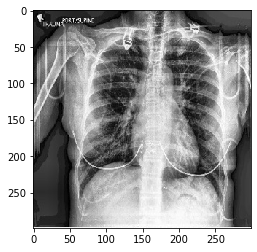

In [32]:
plt.imshow(np.squeeze(img[0]))

In [34]:
img[0].shape

TensorShape([299, 299, 3])

In [25]:
test[0].shape

TensorShape([299, 299, 3])

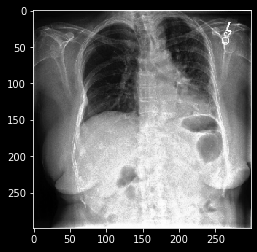

In [16]:
plt.figure()
plt.imshow(np.squeeze(img[0]), cmap='gray')
plt.show()

In [63]:
os.path.join("/home/easdf/keaf/", "*.tfrecord")

'/home/easdf/keaf/*.tfrecord'

### Inception Resnet

In [22]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

In [28]:
model = InceptionResNetV2(include_top=False,
                      weights='imagenet',
                      input_shape=(299,299,1),
                      classes=13,
                 )

ValueError: The input must have 3 channels; got `input_shape=(299, 299, 1)`

In [30]:
d = preprocess_input(img)

In [31]:
d.shape

TensorShape([10, 299, 299, 1])

In [32]:
model(d)

InvalidArgumentError: input depth must be evenly divisible by filter depth: 1 vs 3 [Op:Conv2D]

In [70]:
test=cv2.imread('/home/scott/CSE6250/Data/Atelectasis/frontal_0.jpg', 0)

In [71]:
test.shape

(320, 390)

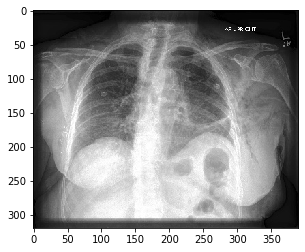

In [72]:
plt.imshow(test,cmap='gray')

In [55]:
output = model(tf.cast(tf.expand_dims(test, 0), tf.float32))

In [56]:
output.shape

TensorShape([1, 8, 10, 1536])

In [74]:
cv2.cvtColor(test,cv2.COLOR_GRAY2RGB).shape

(320, 390, 3)